In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ships-in-satellite-imagery/shipsnet.json
/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/1__20170705_180816_103e__-122.32658408124291_37.706907776737474.png
/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20171023_190147_0f2e__-122.44931218477075_37.74813135712905.png
/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20170917_190616_0f3c__-122.41281471377471_37.81179510079203.png
/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/1__20170709_181333_0e0e__-122.36013529353468_37.77093483120248.png
/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20161116_180802_0e14__-122.49999218351591_37.88828552016498.png
/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20180710_182341_1011__-122.08261432972722_37.73854704083466.png
/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/1__20180708_182358_1032__-122.34681533273329_37.759451149806985.png
/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0_

In [4]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
from numpy import expand_dims
import pandas as pd
import json
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [7]:
with open('/kaggle/input/ships-in-satellite-imagery/shipsnet.json') as data_file:
    dataset = json.load(data_file)
shipsnet= pd.DataFrame(dataset)
shipsnet.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


In [8]:
shipsnet = shipsnet[["data","labels"]]
shipsnet.head()

,data,labels
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1


In [9]:
ship_images = shipsnet["labels"].value_counts()[0]
no_ship_images = shipsnet["labels"].value_counts()[1]
print("Number of the ship_images :{}".format(ship_images),"\n")
print("Number of the ship_images :{}".format(no_ship_images))

Number of the ship_images :3000 

Number of the ship_images :1000


In [10]:
# Turning the json information into numpy array and then assign it as x and y variables
x = np.array(dataset['data']).astype('uint8')
y = np.array(dataset['labels']).astype('uint8')

In [11]:
x_reshaped = x.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
x_reshaped.shape

(4000, 80, 80, 3)

In [12]:
import numpy as np

def add_padding(x_reshaped, target_size):
    padded_images = []
    for image in x_reshaped:
        # Get the current image size
        height, width, channels = image.shape

        # Calculate the amount of padding needed
        pad_height = max(target_size[0] - height, 0)
        pad_width = max(target_size[1] - width, 0)

        # Calculate the top, bottom, left, and right padding values
        pad_top = pad_height // 2
        pad_bottom = pad_height - pad_top
        pad_left = pad_width // 2
        pad_right = pad_width - pad_left

        # Pad the image with zeros
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), mode='constant')
        padded_images.append(padded_image)

    return np.array(padded_images)

In [13]:
# Assuming x_reshaped is an array of shape (4000, 80, 80, 3)
target_size = (224, 224, 3)
padded_images = add_padding(x_reshaped, target_size)
print(padded_images.shape)  # Output: (4000, 224, 224, 3)

(4000, 224, 224, 3)


In [14]:
x_reshaped = padded_images/255

In [15]:
x_reshaped.shape

(4000, 224, 224, 3)

In [16]:
y.shape

(4000,)

In [17]:
y_reshaped = to_categorical(y, num_classes=2)

y_reshaped.shape

(4000, 2)

In [18]:
y_reshaped

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [19]:
x_reshaped[0][0][0] # Normalized RGB values of the firs pixel of the first image in the dataset.

array([0., 0., 0.])

In [20]:
x_train_1, x_test, y_train_1, y_test = train_test_split(x_reshaped, y_reshaped,
                                                        test_size = 0.20, random_state = 42)


x_train, x_val, y_train, y_val = train_test_split(x_train_1, y_train_1, 
                                                  test_size = 0.25, random_state = 42)


print("x_train shape",x_train.shape)
print("x_test shape",x_test.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_test.shape)
print("y_train shape",x_val.shape)
print("y_test shape",y_val.shape)
print("x_train_1 shape",x_train_1.shape)
print("x_val shape",x_val.shape)
print("y_train_1 shape",y_train_1.shape)

x_train shape (2400, 224, 224, 3)
x_test shape (800, 224, 224, 3)
y_train shape (2400, 2)
y_test shape (800, 2)
y_train shape (800, 224, 224, 3)
y_test shape (800, 2)
x_train_1 shape (3200, 224, 224, 3)
x_val shape (800, 224, 224, 3)
y_train_1 shape (3200, 2)


In [21]:
x_test.shape

(800, 224, 224, 3)

In [22]:
x_train.shape

(2400, 224, 224, 3)

**SqeezeNet**

In [23]:
pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [25]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.regularizers import l2  # Import the l2 regularization function

# Load the EfficientNetB0 model pretrained on ImageNet dataset without the fully connected layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

n_classes = 2
base_model.trainable = True

# Unfreeze the last 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Create the model by adding custom Dense layers on top of the base model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # L2 regularization
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the model
model.summary()

# Rest of the code for custom Affine Transformation Function, Data Augmentation, Learning Rate Scheduler, and Model Training can remain unchanged.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functiona  (None, 7, 7, 1280)        4049564   
 l)                                                              
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 4131678 (15.76 MB)
Trainable params: 143

In [28]:
import cv2
# Custom Affine Transformation Function
def apply_affine_transform(image):
    # Define the affine transformation parameters
    shear_range = 20
    translation_range = 0.2
    zoom_range = [0.8, 1.2]
    rotation_range = 20

    # Apply the affine transformations
    rows, cols, _ = image.shape
    shear = np.random.randint(-shear_range, shear_range)
    translation_x = np.random.randint(-translation_range * cols, translation_range * cols)
    translation_y = np.random.randint(-translation_range * rows, translation_range * rows)
    zoom = np.random.uniform(zoom_range[0], zoom_range[1])
    rotation = np.random.randint(-rotation_range, rotation_range)

    matrix = cv2.getRotationMatrix2D((cols // 2, rows // 2), rotation, zoom)
    matrix[:, 2] += (translation_x, translation_y)

    # Apply shear separately for x and y directions
    shear_matrix = np.array([[1, abs(np.tan(np.deg2rad(shear))), 0],
                             [0, 1, 0]])
    if shear > 0:
        image = cv2.warpAffine(image, shear_matrix, (cols, rows), borderMode=cv2.BORDER_REFLECT_101)
    else:
        image = cv2.warpAffine(image, shear_matrix, (cols, rows), borderMode=cv2.BORDER_REFLECT_101)

    return cv2.warpAffine(image, matrix, (cols, rows), borderMode=cv2.BORDER_REFLECT_101)

# Data Augmentation with Affine Transformations
aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=apply_affine_transform)

from tensorflow.keras.callbacks import LearningRateScheduler

# Define the learning rate schedule function
def lr_schedule(epoch):
    initial_lr = 0.001
    if epoch < 5:
        return initial_lr
    else:
        return initial_lr / 100

# Create the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

BS = 25
EPOCHS = 8

# Fit the model using data augmentation
steps_per_epoch = len(x_train) // BS  # Use integer division

history = model.fit(aug.flow(x_train, y_train, batch_size=BS),
                    steps_per_epoch=steps_per_epoch,
                    epochs=EPOCHS,
                    validation_data=(x_test, y_test),
                    callbacks=[lr_scheduler])


Epoch 1/8
96/96 [==============================] - 145s 2s/step - loss: 0.1011 - accuracy: 0.9704 - val_loss: 0.0515 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 2/8
96/96 [==============================] - 155s 2s/step - loss: 0.1169 - accuracy: 0.9692 - val_loss: 0.1273 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 3/8
96/96 [==============================] - 152s 2s/step - loss: 0.1218 - accuracy: 0.9675 - val_loss: 0.0643 - val_accuracy: 0.9862 - lr: 0.0010
Epoch 4/8
96/96 [==============================] - 139s 1s/step - loss: 0.1015 - accuracy: 0.9712 - val_loss: 0.0634 - val_accuracy: 0.9837 - lr: 0.0010
Epoch 5/8
96/96 [==============================] - 151s 2s/step - loss: 0.0847 - accuracy: 0.9767 - val_loss: 0.0563 - val_accuracy: 0.9912 - lr: 0.0010
Epoch 6/8
96/96 [==============================] - 155s 2s/step - loss: 0.0802 - accuracy: 0.9762 - val_loss: 0.0438 - val_accuracy: 0.9912 - lr: 1.0000e-05
Epoch 7/8
96/96 [==============================] - 152s 2s/step - loss: 0.0827

In [29]:
model.evaluate(x_test, y_test)

25/25 [==============================] - 32s 1s/step - loss: 0.0440 - accuracy: 0.9887


[0.0440204031765461, 0.9887499809265137]

25/25 [==============================] - 32s 1s/step

Test Accuracy Score :  0.98875 



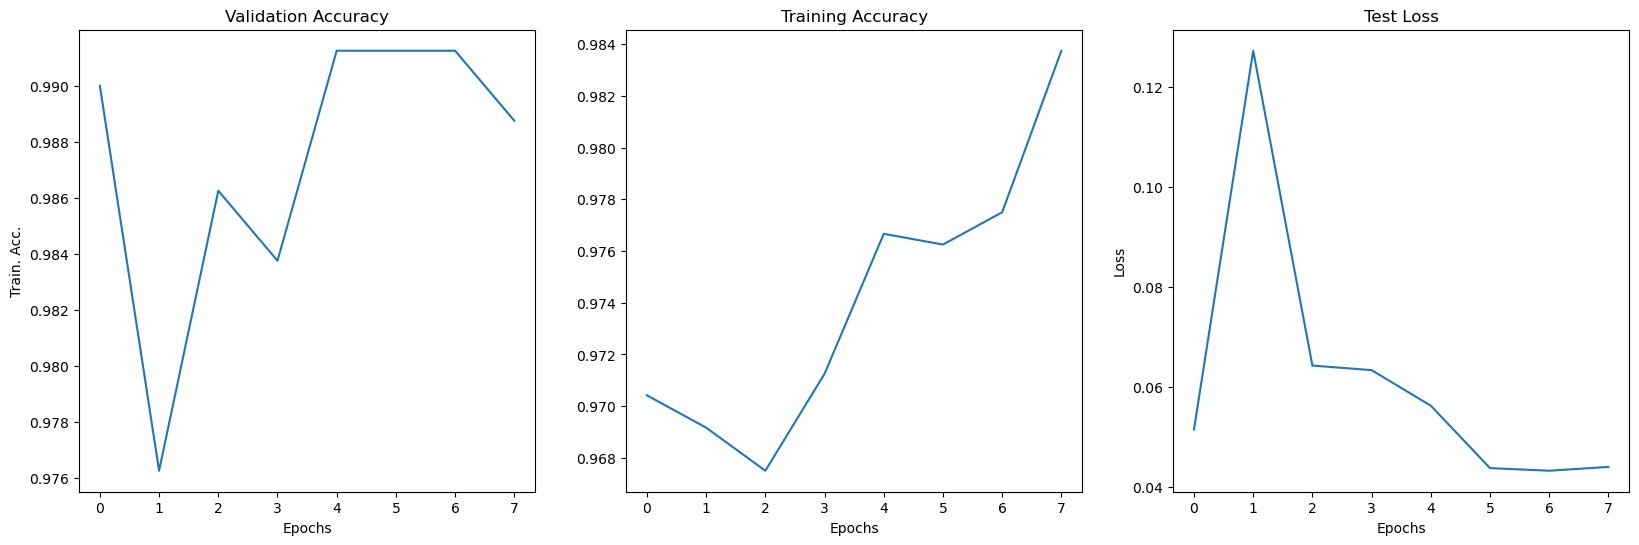

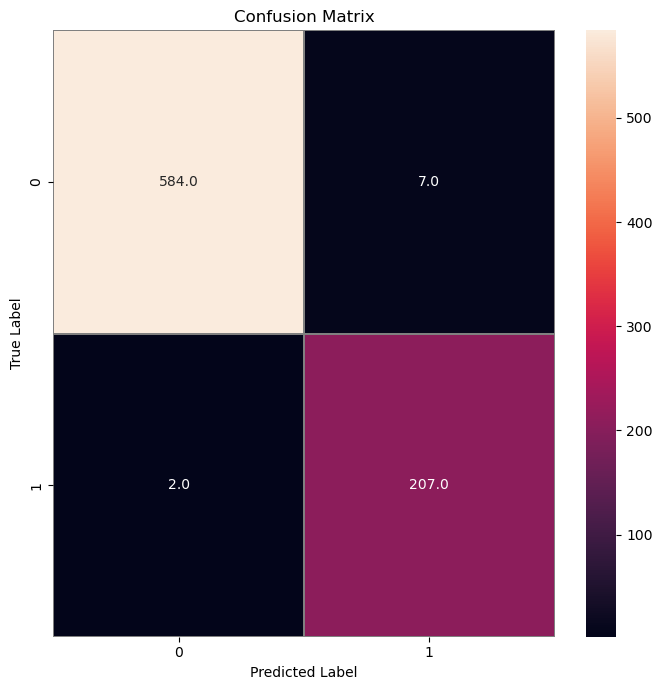

In [30]:
from sklearn import metrics
import seaborn as sns
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# Compute the confusion matrix

print("\n""Test Accuracy Score : ",metrics.accuracy_score(Y_true, Y_pred_classes),"\n")

fig, axis = plt.subplots(1, 3, figsize=(20,6))
axis[0].plot(history.history['val_accuracy'], label='val_acc')
axis[0].set_title("Validation Accuracy")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Val. Acc.")
axis[1].plot(history.history['accuracy'], label='acc')
axis[1].set_title("Training Accuracy")
axis[1].set_xlabel("Epochs")
axis[0].set_ylabel("Train. Acc.")
axis[2].plot(history.history['val_loss'], label='val_loss')
axis[2].set_title("Test Loss")
axis[2].set_xlabel("Epochs")
axis[2].set_ylabel("Loss")

plt.show()


confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# Plot the confusion matrix
f,ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()

plt.show()

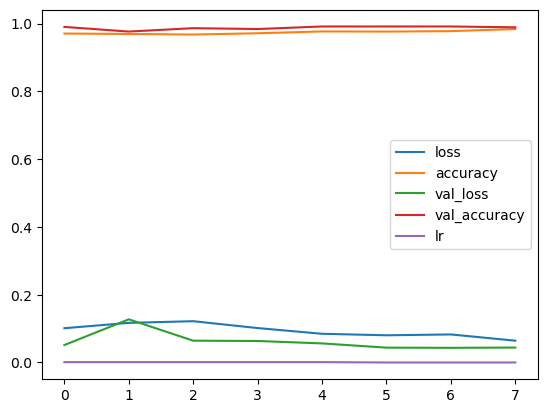

In [31]:
pd.DataFrame(history.history).plot();

In [32]:
prediction = model.predict(x_test)
pd.Series(prediction[0], index=["Not A Ship", "Ship"])

25/25 [==============================] - 29s 1s/step


Not A Ship    0.002335
Ship          0.997665
dtype: float32

In [33]:
predicted_data = pd.DataFrame(prediction, columns=["Not A Ship", "Ship"])
predicted_data.head()

,Not A Ship,Ship
0,0.002335,9.976653e-01
1,0.999999,7.782817e-07
2,0.002760,9.972398e-01
3,0.999834,1.659636e-04
4,0.999985,1.524927e-05


In [34]:
y_test_data = pd.DataFrame(y_test, columns=["Not A Ship", "Ship"])
y_test_data.head()

,Not A Ship,Ship
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0
3,1.0,0.0
4,1.0,0.0


In [35]:
predicted_data['There is a Ship'] = y_test[:, 1]
predicted_data.head()

,Not A Ship,Ship,There is a Ship
0,0.002335,9.976653e-01,1.0
1,0.999999,7.782817e-07,0.0
2,0.002760,9.972398e-01,1.0
3,0.999834,1.659636e-04,0.0
4,0.999985,1.524927e-05,0.0


In [36]:
predicted_data["Difference"] = predicted_data["Ship"] - predicted_data["There is a Ship"]
predicted_data

,Not A Ship,Ship,There is a Ship,Difference
0,0.002335,9.976653e-01,1.0,-2.334654e-03
1,0.999999,7.782817e-07,0.0,7.782817e-07
2,0.002760,9.972398e-01,1.0,-2.760231e-03
3,0.999834,1.659636e-04,0.0,1.659636e-04
4,0.999985,1.524927e-05,0.0,1.524927e-05
...,...,...,...,...
795,0.855407,1.445929e-01,0.0,1.445929e-01
796,0.002313,9.976866e-01,1.0,-2.313375e-03
797,0.999999,6.816430e-07,0.0,6.816430e-07
798,0.999999,1.459972e-06,0.0,1.459972e-06


In [37]:
predicted_data.sort_values('Difference', ascending=False).head(10)

,Not A Ship,Ship,There is a Ship,Difference
180,0.083734,0.916266,0.0,0.916266
461,0.173794,0.826206,0.0,0.826206
717,0.213098,0.786902,0.0,0.786902
191,0.236012,0.763988,0.0,0.763988
185,0.416409,0.583591,0.0,0.583591
493,0.422816,0.577184,0.0,0.577184
749,0.425478,0.574521,0.0,0.574521
528,0.509501,0.490499,0.0,0.490499
217,0.587660,0.412339,0.0,0.412339
536,0.675187,0.324813,0.0,0.324813


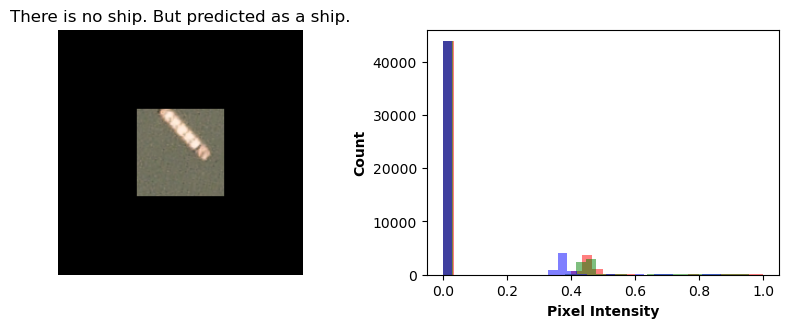

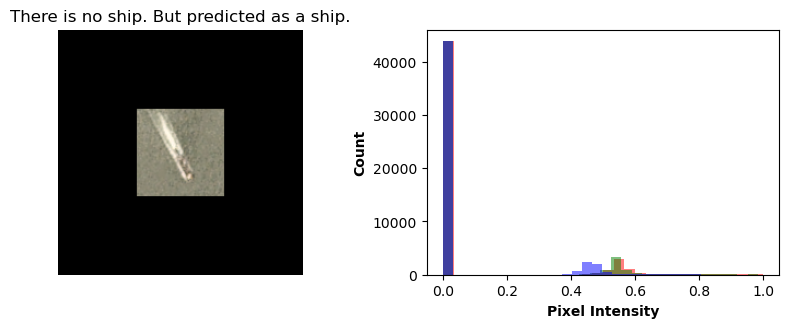

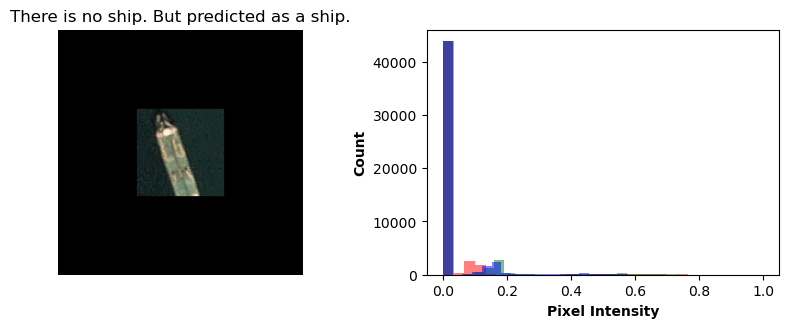

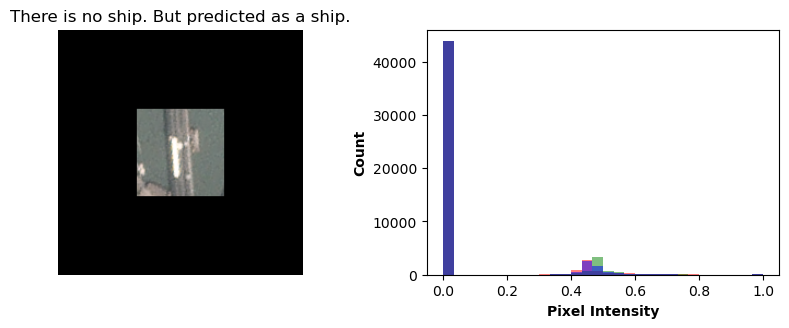

In [38]:
indexes = predicted_data.sort_values('Difference', ascending = False).head(4).index.to_list()

def plotHistogram(image_index):

    plt.figure(figsize = (10,7))
    plt.subplot(2,2,1)
    plt.imshow(x_test[image_index])
    plt.axis('off')
    plt.title('There is no ship. But predicted as a ship.')
    histo = plt.subplot(2,2,2)
    histo.set_ylabel('Count', fontweight = "bold")
    histo.set_xlabel('Pixel Intensity', fontweight = "bold")
    n_bins = 30
    plt.hist(x_test[image_index][:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
    plt.hist(x_test[image_index][:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
    plt.hist(x_test[image_index][:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
    plt.show()


for i in indexes:
    plotHistogram(i)

In [39]:
import pickle

# Assuming you have already trained the model and stored it in the 'model' variable
# Save the model to a file using pickle
with open('/kaggle/working/efficientnet_model.pkl', 'wb') as f:
    pickle.dump(model, f)
